In [31]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Training Models

So far we have treated machine learning models and their training algorithms mostly like black boxes. If you went through some of the exercises in the previous chapters, you may have been suprised by how much you can get done without knowing anything about whats going on under the hood: you optimized a regression system., you improved a digit image classifier, and you even guilt a spam classifier from scratch., all without knowing how they actually work. Indeed, in many situations you don't really need to know the implimentation details. 

However, having a good understanding of things can help you quickly home in on the appropriate model, the right training algorithm to use, and a good set of hyperparameters for your task. Understanding what's under the hood will also help you debug issues and perform error analysis more efficiently. Lastly most of the topics discussed in this chapter will be essential in understanding, building, and training neural networks. 

In this chapter, we will start by looking at a linear regression model, on of the simplest models there is. We will discuss two very different ways to train it:

- Using a "closed-form" equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set). 

- Using an iterative optimization approach called gradient descent (GD) that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converting to the same set of parameters as the first method. We will look at a few variants of gradient descent that we will use again and again when we study neural networks in Part II: batch GD, mini-batch GD, and stochastic GD. 

Next we will look at polynomial regression, a more complex model that can fit non-linear datasets. Since this model has more parameters than linear regression, it is more prone to overfitting the training data. We will explore how to detect whether or not this is the case using learning curves, and then we will look at a regularlization techniques that can reduce the reisk of overfitting the training set. 

Finally, we will examine two more models that are commonly used for classification tasks: logistic regression and softmax regression.

## Linear Regression

In chapter 1 we looked at a simple regression model of life satisfaction:

$ \text{Life Satisfaction} \quad = \quad \theta_{0} + \theta_{1} \times \text{ GDP Per Capita}$ 

This model is just a linear function of the input feature `GDP_per_capita`. $\theta_{0}$ and $\theta_{1}$ are the model's parameters. 

More generally, a linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the *bias term* (also called the *intercept term*)

*Equation 4-1: Linear Regression Model Prediction*

$\hat{y} = \theta_0  + \theta_1x_1 + \theta_2x_2 + \dots + \theta_nx_n$ 

In this equation:
- $\hat{y}$ is the predicted value
- $n$ is the number of features
- $x_{1}$ is the $i^{th}$ feature value
- $\theta_{j}$ is the $j^{th}$ model parameter, including the bias term $\theta_{0}$ and the features weights $\theta_{1}$, $\theta_{2}$, $...$, $\theta_{n}$.

This can be written much more concisely using a vectorized form, as shown in equation 4-2.

*Equation 4-2: Linear Regression Model Prediction (vectorized form)*

$\hat{y}$ = $h_{\theta}$ = $\theta$ * $x$

In this equation:
- $h_{\theta}$ is the hypothesis function, using the model parameters $\theta$.
- $\theta$ is the model's *parameter vector, containing the bias term $\theta_{0}$ and the feature weights $\theta_{1}$ to $\theta_{n}$.
- $x$ is the instance's *feature vector*, containing $x_{0}$ to $x_{n}$, with $x_{0}$ always equal to 1.
- $\theta * x$ is the dot product of the vectors $\theta$ and $x$, which is equal to $\theta_{0}x_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n}x_{n}$.



In machine learning, vectors are often represented as *column vectors*, which are 2D arrays with a single column. If $\theta$ and $x$ are column vectors, then the prediction is $\hat{y}$ = $\theta^{T}x$, where $\theta^{T}$ is the *transpose* of $\theta$ (a row vector instead of a column vector) and $\theta^{T}x$ is the matrix multiplication of $\theta^{T}$ and $x$. It is of course the same prediction, except that it is now represented by a single cell matrix rather than a scalar value. In this book I will use this notation to avoid switching between dot products and matrix multiplications.

Ok, that's the linear regression model-- but how do we train it? Well, recall that training a model means setting its prameters so that the model best fits the training set. For this purpose, we first need a measure of how well, (or poorly) the model fits the training data. In chapter 2 we saw that the most common performance measure of a regression model is the root mean square error (equation 2-1). Therefore, to train a linear regresssion model, we need to find the value of $\theta$ that minimizes the RMSE. In practice, it is simpler to minimize the mean squared error (MSE) than the RMSE, and it leads to the same result (Because the value that minimizes a positive function also minimizes its square root). 

- Learning algoritms will often optimize a different loss function during training than the perfromance measure used to evaluate the final model. This is generally because the function is easier to optimize and/or because it has extra terms needed during training only. (e.g., for regularization). A good performance metric is as close as possible to the final business objective. A good training loss is easy to optimize and strongly correlated with the metric. For example, classifiers are often trained using a cost function such as the log loss (as you will see later in this chapter) but evaluated using precision/recall. The log loss is easy to minimize, and doing so will usually improve precision/recall. 

The MSE of a linear regression hypothesis $h_{\theta}$ on a training set $X$ is calculated using equation 4-3.

*Equation 4-3, MSE cost function for a linear regression model:*


$MSE(X,H_{\theta}) = \frac{1}m\sum \limits _{i=1} ^{m}(\theta^{T}x^{(i)} - y^{(i)})^{2}$

Most of these notations were presented in chapter 2 (see "Notations" on page 44). The only difference is that we write $h_{0}$ instead of just $h$ to make it clear that the model is parameterized by the vector $\theta$. To simplify notations, we will just write $MSE(\theta)$ instaed of $MSE(X,h_{\theta})$.

## The Normal Equation ##

To find the value of $\theta$ that minimizes the MSE, there exists a *closed-form solution*- in other words, a mathematical equation that gives the result directly. This is called the *Normal Equation* (Equation 4-4).

*Equation 4-4, Normal Equation:*

$\hat{\theta} = (X^{T}X)^{-1}  X^{T}  y$

In this equation:

- $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function.
- $y$ is the vector of target values containing $y^{-1}$ to $y^{(m)}$.

Let's generate some linear-looking data to test this equation on:

In [3]:
import numpy as np

np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

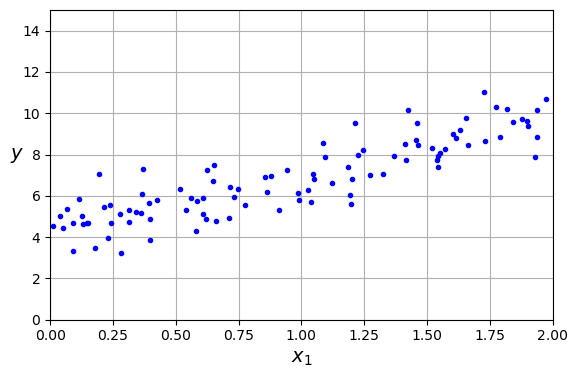

In [4]:
# extra code – generates and saves Figure 4–1

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("generated_data_plot")
plt.show()

Now let's compute $\hat{\theta}$ using the Normal equation. We will use the `inv()` function from NumPy's linear algebra module `(np.linalg)` to compute the inverse of a matrix, and the `dot(0)` method for matrix multiplication:

In [5]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X) # add x0=1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

- The `@` operator performs matrix multiplication. If A and B are NumPy arrays, then A @ B is equivalent to `np.matmul(A, B)`. Many other libraries, like TensorFlow, PyTorch, and JAX, support the @ operator as well. However, you cannot use @ on pure Python arrays (i.e., lists of lists).

The function that we used to generate the data is $y = 4 + 3x_{i} +$ Gaussian Noise. Let's see what the equation found:

In [6]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for $\theta_{0} = 4$ and $\theta_{1} = 3$ instead of $\theta_{0} = 4.215$ and $\theta_{1} = 2.770$, but the noise made it impossible to recover the exact parameter of the original function. The smaller and noisier the dataset, the harder it gets. 

Now we can make predictions using $\hat{\theta}$:

In [7]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new) # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

Let's plot the models predictions:

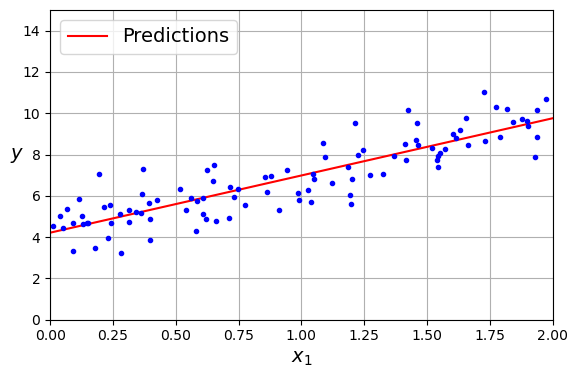

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
save_fig("linear_model_predictions_plot")

plt.show()

Peforming linear regression using scikit learn is relatively straightforward:

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

Notice that scikit learn separates the bias term (`intercept_`) from the beature weights (`coef_`). The `linearregression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you would call directly. 

In [11]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

The function computes $\hat{\theta} = X^{+}y$, where $X^{+}$ is the *pseudoinverse* of $X$ (spcecifically the moore-penrose inverse). You can use `np.linalg.pinv()` to compute the pseudo inverse directly:

In [12]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

The pseudo inverse itself is computed using a standard matrix factorization technique called singular value decomposition (SVD) that can decompose the training set matrix **X** into the matrix multiplication of three matrices $\text{U} \mathbf{\Sigma} \text{V}^\top$ (see `np.linalg.svd()`). The pseudoinverse is computed as $X^+ = \text{V} \Sigma^+ \text{U}^\top$. To compute the matrix $\Sigma^\top$, the algorithm takes $\Sigma$ and sets to zero all values smaller than a tiny threshold value, then it replaces all the nonzero values with their inverse, and finally it transposes the resulting matrix. This approach is more efficient than computing the normal equation, plus it handles edge cases nicely: Indeed, the normal equation may not work if the matrix $X^\top X$ is not invertible (i.e., singular), such as if $m < n$ or if some features are redundant, but the pseudoinverse is always defined. 


### Computational Complexity
The normal equation computes the inverse of $X^\top X$, which is an $(n + 1) \times (n + 1)$ matrix (where $n$ is the number of features). The *computational complexity* of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$, depending on the implementation. In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5$ to $2^3 = 8$. 

The SVD approach used by scikit learn's linear regression class is about $O(n^2)$. If you double the number of features, you multiply the computation time by roughly 4. 

Also, once you have trained your linear regression model, predictions are very fast.

### Gradient Descent

*Gradient Descent* is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of gradient descent is to tweak parameters iteratively in order to minimize a cost function.

Suppose you are lost in the mountains in a dense fog, and you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley is to go downhill in the direction of the steepest slope. This is exactly what gradient descent does: it measures the local gradient of the error function with regard to the parameter vector $\theta$, and it goes in the direction of the descending gradient. Once the gradient is 0, you have reached a minimum!

In practice, you start by filling $\theta$ with random values. (this is called *random initialization*). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function. (e.g., the MSE), until the algorithm *converges* to a minimum. 

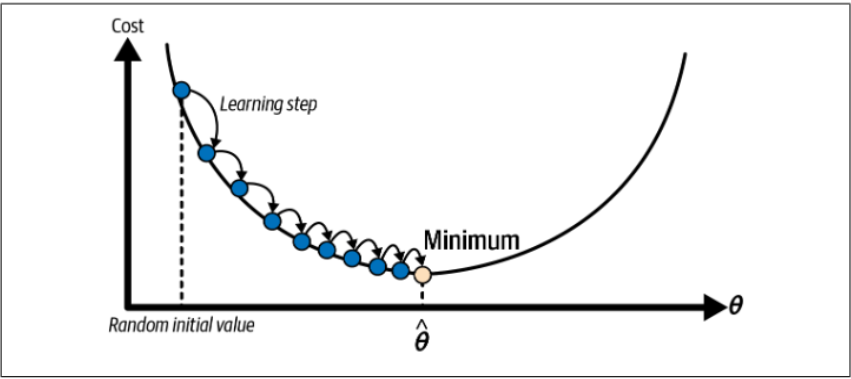

An important parameter in gradient descent is the size of the steps, determined by the *learning rate* hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge which will take a long time.

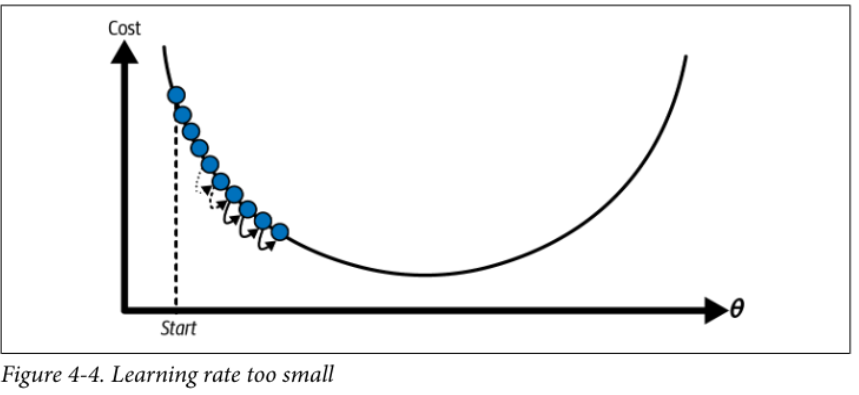

On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution. 

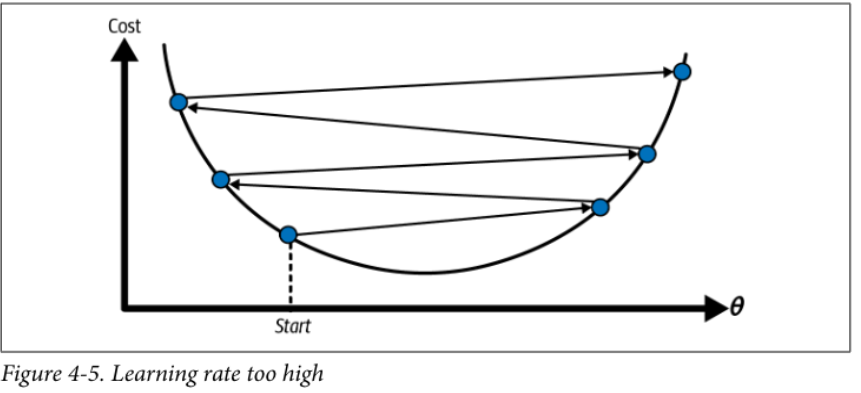

Additionally, not all cost functions look like nice regular bowls. There may be holes, ridges, and all sorts of irregular terrain, making convergence to a minimum difficult. 

- If the random initialization starts the algorithm on the left, then it will converge to a *local minimum*. 
- If it starts on the right, then it will take a very long time to cross the plateau.
- If you stop too early, you will never reach the globabl minimum. 

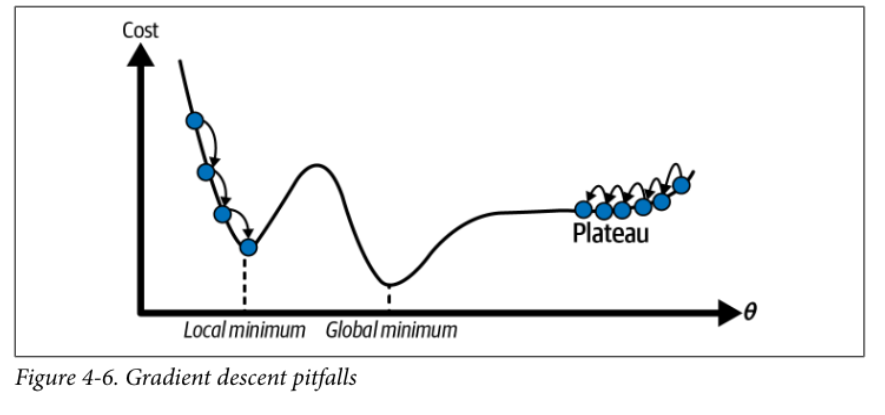


Fortunately, the MSE cost function for linear regression happens to be a *convex function*, which means that if you pick any two points on the curve, the line segment joining them is never below the curve. This implies that there is no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptbly. These two facts have a great consequence: Gradient Descent is guaranteed to approach arbitrarily closely to the global minimum. 

While the cost function has the shape of a bowl, it can be an elongated bowl if the features have very different scales. The below figure shows gradient descent where features 1 and 2 have the same scale (on the left) and on a training set where feature 1 has much smaller values than feature 2 (on the right).

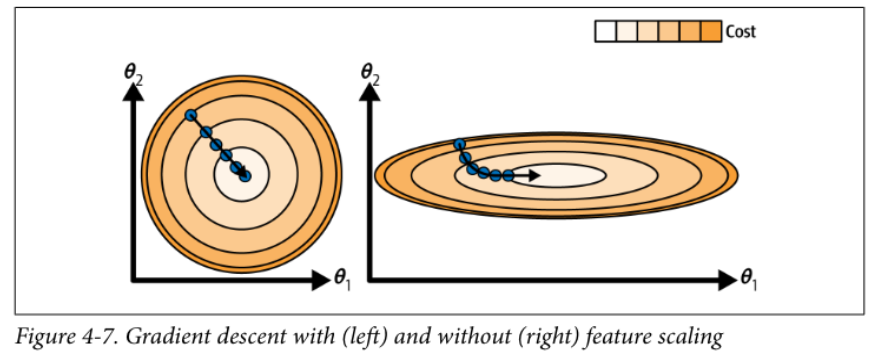

As you can see, on the left the gradient descent algorithm goes straight toward the minimum, whereas on the right it first goes in a direction almost orthogonal to the direction of the global minimum, and ends with a long march down an almost flat valley. It will eventually reach the minimum, but it will take a long time.

Training a model also means searching for a combination of model parametters that minimizes a cost function (over the training set). It is a search for the models *parameter space*. The more parameters a model has, the more dimensions this space has, and the harder the search is.

## Batch Gradient Descent
To implement gradient descent, you need to compute the gradient with regard to each model parameter $(\theta{j})$. In other words, you need to calculate how much the cost function will change if you change $(\theta{j})$ just a little bit. This is called a *partial derivative*.

The following equation computes the partial derivative of the MSE with reagard to parameter $\theta{j}$, noted $\partial \text{MSE} (\theta_j) / \partial \theta_j$.

#### Equation 4-5. Partial derivatives of the cost function

$
\frac{\partial}{\partial \theta_j} \text{MSE}(\theta) = \frac{2}{m} \sum_{i=1}^m \left( \theta^\top \mathbf{x}^{(i)} - y^{(i)} \right) x_j^{(i)}
$

Instead of computing these partial derivatives individually, you can use **Equation 4-6** to compute them all in one go. The gradient vector, noted $\nabla_\theta \text{MSE}(\theta)$, contains all the partial derivatives of the cost function (one for each model parameter).

#### Equation 4-6. Gradient vector of the cost function

$
\nabla_\theta \text{MSE}(\theta) =
\begin{bmatrix}
\frac{\partial}{\partial \theta_0} \text{MSE}(\theta) \\
\frac{\partial}{\partial \theta_1} \text{MSE}(\theta) \\
\vdots \\
\frac{\partial}{\partial \theta_n} \text{MSE}(\theta)
\end{bmatrix}
= \frac{2}{m} \mathbf{X}^\top (\mathbf{X}\theta - \mathbf{y})
$

Notice that this formula invovles calculations over the full training set $X$, at each gradient descent step. This is why the algoritm is called *batch gradient descent*: it uses the whole batch of training data at every step. 

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting $\nabla_{\theta} \text{MSE}(\theta)$ from $\theta$. This is where the learning rate $\eta$ comes into play: Multiply the gradient vector by $\eta$ to determine the size of the downhill step:

#### Equation 4-7 Gradient Descent Step
$\theta^{\text{ next step }} \quad = \quad \theta - \eta \nabla_{\theta} \text{MSE}(\theta)$

lets look at a quick implementation of this algorithm:

In [13]:
eta = 0.1
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

for epoch in range(n_epochs):
    gradients = 2/m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

Each iteration over the training set is called an epoch. Let's look at the resulting `theta`.

In [14]:
theta

array([[4.21509616],
       [2.77011339]])

- On the left, the learning rate is too low: the algorithm will take a long time to reach the solution.
- In the middle, the learning rate looks pretty good: in a few epochs it has already converged to the solution. 
- On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.

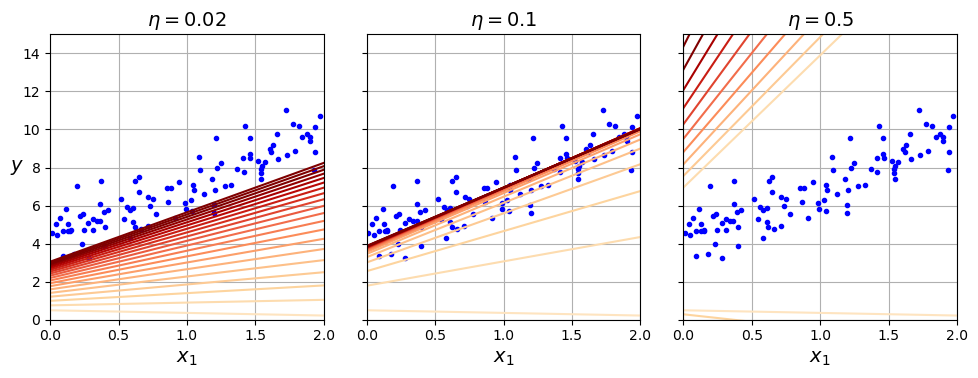

In [15]:
# extra code – generates and saves Figure 4–8

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

To find a good learning rate, you can use grid search. However you may want to limit the number of epochs so that grid search can eliminate models that take too long to converge.

### how to set the number of epochs:
A simple solution is to set a very alrge number of epochs, but to interupt the algorithm when the gradient vector becomes tiny - that is, when its norm becomes smaller than a tiny number $\epsilon$, (called the *tolerance*) - because this happens when gradient descent has almost reached the minimum. 

#### Convergence Rate
When the cost function is convex and its slope does not change abruptly (as is the case fo the MSE cost function), batch gradient descent with a fixed learning rate will eventually converge to the optimal solution, but you may have to wait a while.

### Stochastic Gradient Descent
The main problem with batch gradient descent is that it uses the whole training set to compute the gradients at every step, which makes it very slow when the trainig set is large. At the opposite extreme *stochastic gradient descent* picks a random instance in the training set and computes the gradients based only on that single instance. It also makes it possible to train on huge datasets, since only one instance needs to be in memory at each iteration. 

On the other hand, due to its stochastic (i.e., random nature), this algorithm is much less regular than batch gradient descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average.

- Over time it will end up very close to the minimun,, but once it gets there it will continue to bounce around.
- Once the algorithm stops, the final parameter values will be good, but not optimal.

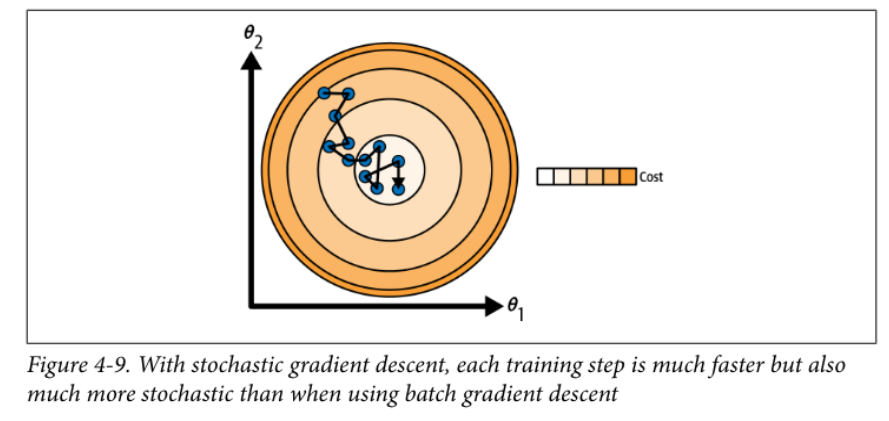

When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so stochastic gradient descent has a better chance of finding the global minimum than batch descent does. One solution to this dilemma is to gradually reduce the learning rate. The steps start out large, then get smaller and smaller, allowing the algorithm to settle at the global minimum. The function that determines the learning rate at each iteration is called the *learning schedule*. 

This code implments stochastic gradient descent using a simple learning schedule:

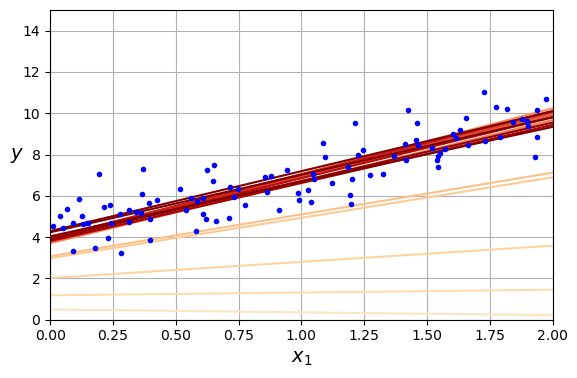

In [16]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("sgd_plot")
plt.show()

By convention, we iterate by raounds of $m$ iterations; each round is called an *epoch* as earlier. While the batch gradient descent code iterated 1,000 times through the whole training set, this code goes through the training set only 50 times and reaches a pretty good solution:

In [17]:
sgd_theta = theta
print(sgd_theta)
print(theta_best)

[[4.21076011]
 [2.74856079]]
[[4.21509616]
 [2.77011339]]


To perform linear regression using stochastic GD with scikit learn, you can use the `SGDRegressor` class, which defaults to optimizing the MSE cost function. The following code runs for maximum 1,000 epochs (`max_iter`) or until the loss drops by less than $10^{-5}$ (`tol`) during 100 epochs (`n_iter_no_change`). it starts with a learning rate of 0.01(`eta0`), using default learning schedule (different from the one we used). lastly it does not use any regularization (`penalty=none`):

In [18]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

Once again, you find a solution quite close ot the one returned by the Normal Equation:

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

### Mini-Batch Gradient Descent
The last gradient descent algorithm we will look at is called *mini-batch gradient descent*. It is straightforward once you know batch and stochastic gradient descent: 
- At each step, instaed of computing the gradients based on the full training set (as in batch GD), or based on just one instance (as in stochastic GD), mini-batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of mini-batch GD over stochasatic GD is that you get a performance boots from hardware optimization, especially when using GPUs. 

The algorithms progress in parameter space is less erratic than with stochastic GD, especially with fairly large mini-batches. As a result, mini-batch GD will end up walking a bit closer to the minimum than stochastic GD, but it may be harder to escape from local minima (in the case of problems that suffer from local minima, unlike linear regression with the MSE cost function.)

The below figure shows thet paths taken by the three gradient descent algorithms in parameter space during training. They all end up near the minimum, but batch GD's path actually stops at the minimum, while both stochastic and mini-batch GD continue to walk around. Don't forget that Batch GD takes a long time, while stochastic and mini-batch GD would also reach the minimum if you used a good learning schedule. 

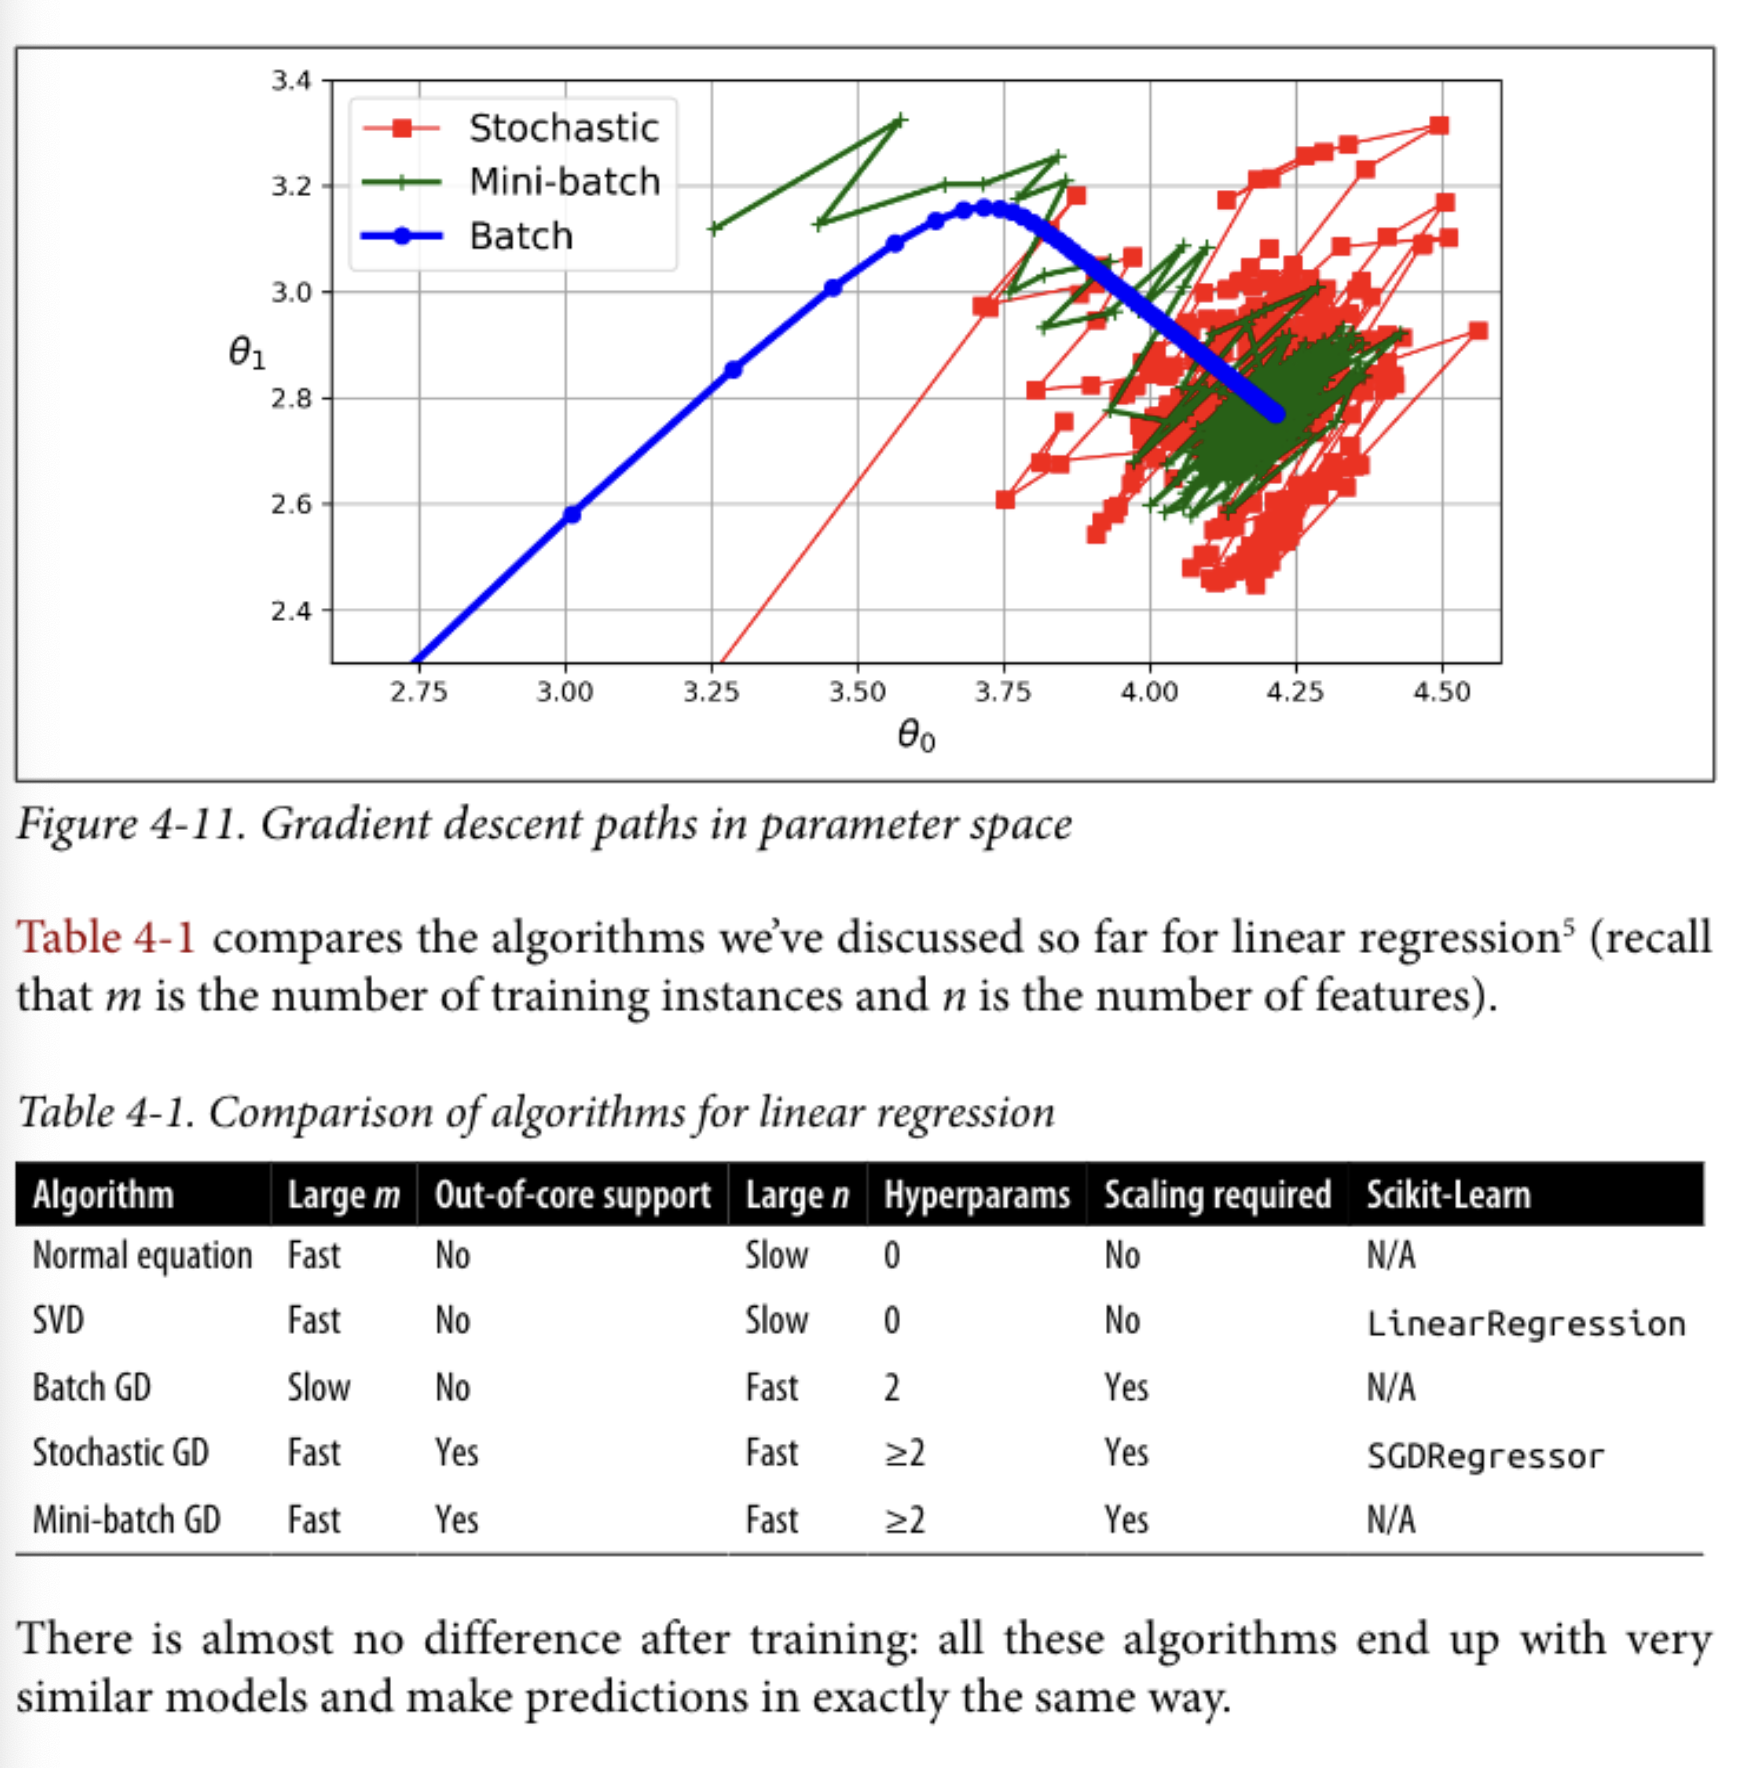

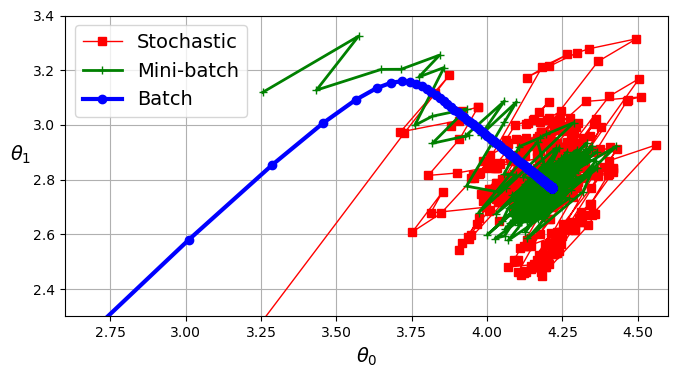

In [20]:
# extra code – this cell generates and saves Figure 4–11

from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
save_fig("gradient_descent_paths_plot")
plt.show()

### Polynomial Regression
What if your data is more complex than a straight line? Suprisingly you can use a non-linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features, this technique is called *polynomial regression*.

Let's look at an example> first we'll generate some non-linear data, based on the quadratic equation (that's an equation in the form of $ax^2 + bx + c$, plus some noise):

In [21]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

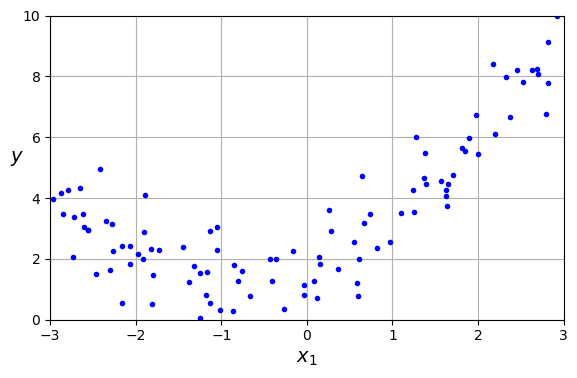

In [22]:
# extra code – this cell generates and saves Figure 4–12
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_data_plot")
plt.show()

Clearly, a straight line will never fit this data properly. So lets use Scikit-Learn's `PolynomialFeatures` class to transform our training data, adding the square (second-degree polynomial) of each feature in the training set as a new feature (in this case there is just one feature):

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [24]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original feature of `X` plus the square of this feature. Now we can fit a `LinearRegression` model to this extended training data:

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

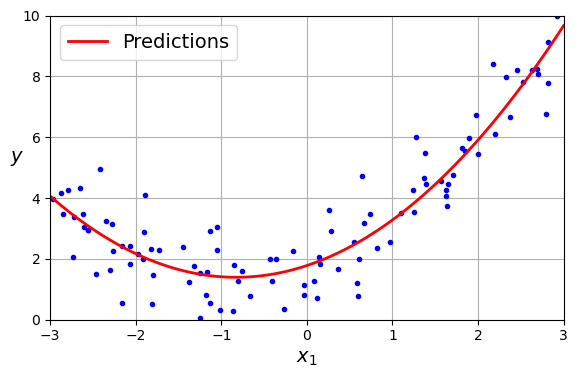

In [26]:
# extra code – this cell generates and saves Figure 4–13

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_predictions_plot")
plt.show()

Not bad: the model estimate $\hat{y}$ = 0.56x_1^2 + 0.93x_1 + 1.78 when in fact the original function was $y = 0.5x_1^2 + 1.0x_1 + 2.0 + \text{gaussian noise}$. 

Those that when there are multiple features, polynomial  regression is capable of finding relationshisp between features, which is something  a plain linear regression model cannot do. THis is made possible by the fact that `PolynomialFeatures` also adds all combinations of features up to the given degree. For example, if there wer two features $a$ and $b$, `PolynomialFeatures` with `degree=3` would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^2b$ and $ab^2$. 

### Learning Curves
If you perform a high-degree polynomial regresion, you will likely fit training data much better than with plain linear regression. For example, the below figure applies a 300-degree polynomial to the preceding training data, and compares the result with a pure linear model and a quadratic model (second degree polynomial). Notice how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.

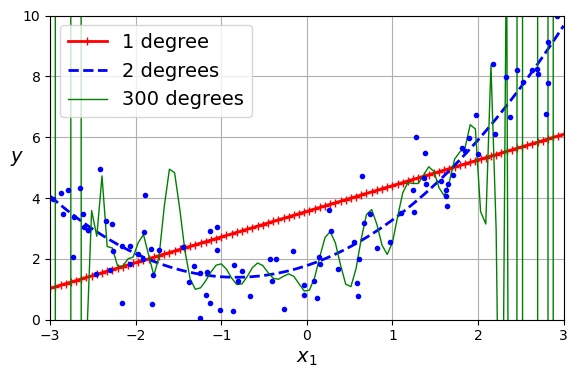

In [27]:
# extra code – this cell generates and saves Figure 4–14

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("high_degree_polynomials_plot")
plt.show()

The high-degree polynomial regression model is severely overfitting the training data, while the linear model is underfitting it. The model that will generalize best is the quadratic model (which makes sense because a quadratic model generated the example data). 

In general, you won't know what function generated the data, sow how can you decide how complex your model should be? How can you tell if your model is underfitting the data? 

We previously used cross validation to get an estimate of a model's generalization performance.
- If a model performs well on the training data but generalizes poorly, then your model is overfitting.
- if it performs poorly on both, then it is underfitting (this is one way to tell if a model is too complex)

Another way to tell is to look at the *learning curves* which are plots of the models training error and validation error as a function of the training iteration:
- Just evaluate the model at regular intervals during training on obth the training set and the validation set, and plot the results. If the model cannot be trained incrementally (i.e., it does not support `partial_fit()` or `warm_start`), then you must train it several times on gradually larger subsets of the training set.

Sci-kit learn has a useful `learning_curve()` function to help with this. It trains and evaluates the model using cross-validation. By default, it retrains the model on growing subsets of the training set, but if the model supports incremental learning you can set `exploit_incremental_learning=True` when calling `learning_curve()` and it will train the model incrementally instead. 

The function returns the the training set sizes at which it evaluated the model, and the training and validation scores it measured for each size and each cross validation fold. Let's use this function to look at the learning curves for the plain linear regression model:

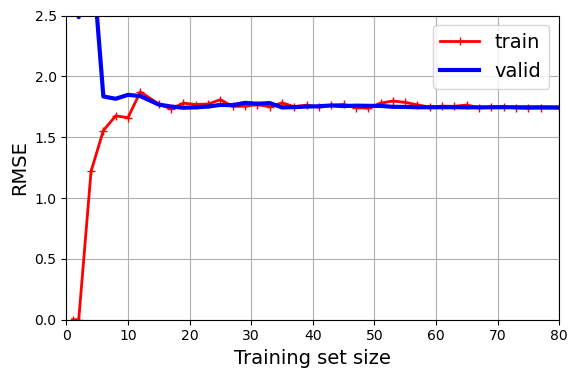

In [28]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
save_fig("underfitting_learning_curves_plot")

plt.show()

The model is underfitting. To see why, first let's look at the training error. When there are just one or two instances in the trainign set, this model can fit them perfectly, which is why the curve starts at 0. 

But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training set goes up until it reaches a plateau, at which point adding new instances to the trainign set doesn't make the average error much better or worse. 

Now let's look at the validation error:

WHen the model is trained on very vew training instances, it is incapable of generalizing properly, which is why the validation error is initially quite large. Then, as the model is shown more training examples, it learns, and thus the validation error slowly goes down. However, Once again a straight line cannot do a good job of modeling the data, so the error ends up at a plateau, very close to the learning curve. 

The learning curves are typical of a model that is underfitting. Both curves here have reached a plateau; they are close and fairly high. 

Now let's look at the learning curves of a 10th-degree polynomial model on the same data:

In [29]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

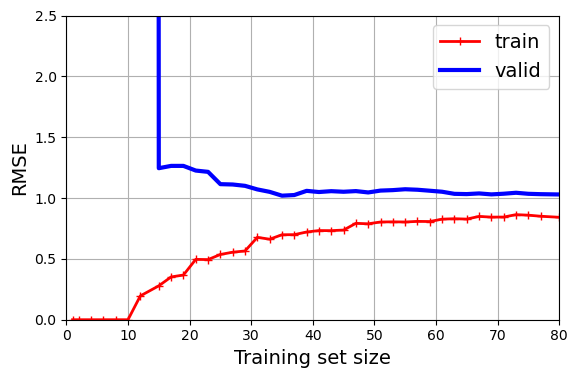

In [30]:
# extra code – generates and saves Figure 4–16

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
save_fig("learning_curves_plot")
plt.show()

These learning curves look a bit like the previous ones, but there are two very important differences:

- the error on the training data is much lower than before
- there is a gap between the curves. This means that the model perforsm significantly better on the training data than on the validation data, which is the hallmark of an overftting model. If you use a much larger training set the two curves would continue to get closer.  One 